# Model recovery attack: `credit-card`

In [1]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import mra
from mra import *
import models
from models import *

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
def make_dataset(X, Y, f):
    x = tf.data.Dataset.from_tensor_slices(X)
    y = tf.data.Dataset.from_tensor_slices(Y)
    x = x.map(f)
    xy = tf.data.Dataset.zip((x, y))
    xy = xy.shuffle(10000)
    return xy

df = pd.read_excel('../datasets/credit-card.xls', header=1, index_col=0).sample(frac=1)
x = df.drop(columns=["default payment next month"]).to_numpy()
x = (x - np.min(x, axis=0))/(np.max(x, axis=0) - np.min(x, axis=0))
y = df["default payment next month"].to_numpy().reshape((len(x), 1)).astype("float32")
train_ds = make_dataset(x, y, lambda t: t)

2022-04-05 05:37:35.666018: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-04-05 05:37:35.666087: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: xgpd6
2022-04-05 05:37:35.666101: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: xgpd6
2022-04-05 05:37:35.666259: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.103.1
2022-04-05 05:37:35.666302: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.103.1
2022-04-05 05:37:35.666313: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.103.1
2022-04-05 05:37:35.666903: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in per

In [3]:
main = {}

for batch_size in [64,128,256]:
    print("Batch size = {}".format(batch_size))
    main[batch_size] = mra(train_ds)
    make_f, make_g, make_generator = models.make_mlp(
        attr_num=23,
        class_num=2,
        split=3,
        fg_units=64,
        fg_act="relu",
        generator_units=[512,256,128,64]
    )
    main[batch_size].train(
        make_f,
        make_g,
        loss_fn=tf.keras.losses.BinaryCrossentropy(),
        batch_size=batch_size,
        epoch=5,
        lr=0.001,
        verbose=True, log_every=1000
    )

Batch size = 64
Iteration 1000: Training loss: 0.4573
Iteration 2000: Training loss: 0.4389
Batch size = 128
Iteration 1000: Training loss: 0.4512
Batch size = 256


In [4]:
log_attack = {}
for batch_size in [64,128,256]:
    print("Dropout = {}".format(batch_size))
    log_attack[batch_size] = main[batch_size].attack(
        attack_iter=100,
        make_generator=make_generator,
        input_noise="normal",
        input_z=True,
        model_leak=True,
        lr_x=0.0001,
        lr_f=0.00001,
        epoch=50,
        iter_x=40,
        iter_f=1,
        verbose=True, log_every=1
    )

Dropout = 64
Iteration 0001: RG-uniform: 0.2345, RG-normal: 0.2133, reconstruction validation: 0.0325
Iteration 0002: RG-uniform: 0.2327, RG-normal: 0.2106, reconstruction validation: 0.0190
Iteration 0003: RG-uniform: 0.2396, RG-normal: 0.2145, reconstruction validation: 0.0131
Iteration 0004: RG-uniform: 0.2237, RG-normal: 0.2218, reconstruction validation: 0.0095
Iteration 0005: RG-uniform: 0.2295, RG-normal: 0.2229, reconstruction validation: 0.0095
Iteration 0006: RG-uniform: 0.2244, RG-normal: 0.2190, reconstruction validation: 0.0074
Iteration 0007: RG-uniform: 0.2160, RG-normal: 0.2044, reconstruction validation: 0.0085
Iteration 0008: RG-uniform: 0.2195, RG-normal: 0.2134, reconstruction validation: 0.0082
Iteration 0009: RG-uniform: 0.2387, RG-normal: 0.2046, reconstruction validation: 0.0079
Iteration 0010: RG-uniform: 0.2374, RG-normal: 0.2153, reconstruction validation: 0.0063
Iteration 0011: RG-uniform: 0.2353, RG-normal: 0.2037, reconstruction validation: 0.0067
Iteratio

In [5]:
import pickle
with open('./log/credit-batch_size.pkl', 'wb') as f:
    pickle.dump(log_attack, f)

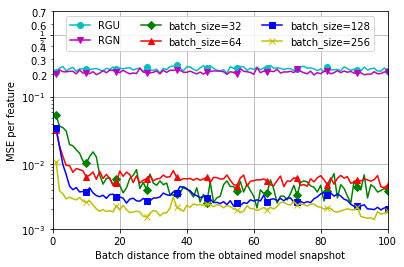

In [15]:
import matplotlib.pyplot as plt

with open('./log/credit.pkl', 'rb') as f:
    log_attack[32] = pickle.load(f)[3]

plt.yscale('logit')
plt.xlim([0,100])
plt.ylim([0.001,0.7])
plt.grid()
plt.ylabel('MSE per feature')
plt.xlabel('Batch distance from the obtained model snapshot')
ran = [i+1 for i in range(100)]
plt.plot(
    ran, log_attack[32][:,0], 'co-',
    ran, log_attack[32][:,1], 'mv-',
    ran, log_attack[32][:,2], 'gD-',
    ran, log_attack[64][:,2], 'r^-',
    ran, log_attack[128][:,2], 'bs-',
    ran, log_attack[256][:,2], 'yx-',
    markevery=np.arange(0, 101, 9))
plt.legend(['RGU', 'RGN', 'batch_size=32', 'batch_size=64', 'batch_size=128', 'batch_size=256'], loc='upper center', ncol=3)
plt.savefig("fig/mra-batch-size.pdf", bbox_inches='tight')